In [1]:
!pip install wandb --quiet
!pip install swig --quiet
!pip install gym[all] --quiet
!pip install pygame --quiet

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
## fixing the pygame error

import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

pygame 2.1.0 (SDL 2.0.16, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


<Surface(640x480x32 SW)>

In [4]:
import gym
from gym.envs import box2d
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
class Policy_NN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size = 128, gamma = 0.99, learning_rate = 0.001):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

        self.optimizer = optim.Adam(self.parameters(),lr=self.learning_rate)


    def forward(self,x):
      x = self.layer1(x) #forward propagation
      x = self.layer2(x)
      x = self.softmax(x)
      return x

    def act(self,state):
        #With obs, find the maximum Q value and output the corresponding action
        #action_probs = torch.softmax(self.actor(obs), dim=-1)
        #state_value = self.critic(state)

        #obs_tensor = torch.as_tensor(obs, dtype=torch.float32)

        #action = log_value.detach().item() #action corresponding to max Q index
        #return action, log_value
        #print("checkpoint 6")
        action_probs = torch.softmax(self.policy_network(state), dim=-1)
        # q_value = self(obs_tensor.unsqueeze(0)) #convert to row vector
        # highest_q_value = torch.argmax(input=q_value)
        # log_value = torch.log(q_value.squeeze(0)[highest_q_value])
        #print("checkpoint 7")
        #print("action_probs: {}".format(action_probs))
        #state_value = self.critic(state)
        return action_probs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
class update_function:
    def __init__(self, Policy_NN, rewards, log_probs_array):
        self.network = Policy_NN
        self.rewards = rewards
        self.log_value = log_probs_array

    def update_function(self):
        discount_rewards = []
        Gt,pw = 0, 0
        for r in reversed(self.rewards):
            Gt = Gt + gamma**pw * r
            pw = pw + 1
            discount_rewards.append(Gt)

        steps_value = np.arange(len(self.rewards))

        discount_rewards = torch.tensor(discount_rewards)
        discount_rewards = discount_rewards[::-1].cumsum()[::-1] / gamma**steps_value

        policy_gradient = []
        for log_prob, e_d_r in zip(self.log_value, discount_rewards):
            policy_gradient.append(-log_prob*e_d_r)

        policy_network.optimizer.zero_grad()
        policy_gradient = torch.stack(policy_gradient).sum()
        policy_gradient.backward()
        policy_network.optimizer.step()

        return policy_gradient

In [7]:
def update(policy_network, gamma = 0.99):
    log_probs = []
    rewards = []

In [8]:
import torch
import numpy as np
import gym
import statistics

In [15]:
def run(policy_network, env, n_episode):
    episodic_reward = []
    for episode in range(n_episode):
        state = env.reset()
        done = False
        log_probs_array = []
        total_reward = 0
        while not done:
            stateT = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action_probs = policy_network(stateT)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action.unsqueeze(0))
            log_probs_array.append(log_prob)
            next_state, reward, done, _ = env.step(action.item())
            total_reward += reward
            update_function(policy_network, reward ,log_probs_array)
            state = next_state

        print("Episode:{} | Reward: {}".format(episode, total_reward))
        episodic_reward.append(total_reward)
        env.close()
    return episodic_reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode:0 | Reward: -444.4517946294101
Episode:1 | Reward: -76.53641552999801
Episode:2 | Reward: -158.19094190207306
Episode:3 | Reward: -199.27581585381748
Episode:4 | Reward: -395.8889269749389
Episode:5 | Reward: -33.868834444192714
Episode:6 | Reward: -585.1818740646597
Episode:7 | Reward: -81.30761277497837
Episode:8 | Reward: -96.25945876269688
Episode:9 | Reward: -166.38596951048606
Episode:10 | Reward: -89.20899203191799
Episode:11 | Reward: -199.77707295237184
Episode:12 | Reward: -61.18008789684749
Episode:13 | Reward: -86.43212016797729
Episode:14 | Reward: -360.9946744206768
Episode:15 | Reward: -174.15699182697912
Episode:16 | Reward: -94.61548950515163
Episode:17 | Reward: -161.05520897599524
Episode:18 | Reward: -329.33955963553217
Episode:19 | Reward: -183.11445890005524
Episode:20 | Reward: -115.69024378302859
Episode:21 | Reward: -197.20888007478496
Episode:22 | Reward: -247.56013054253154
Episode:23 | Reward: -336.42615991297964
Episode:24 | Reward: -294.57571908894

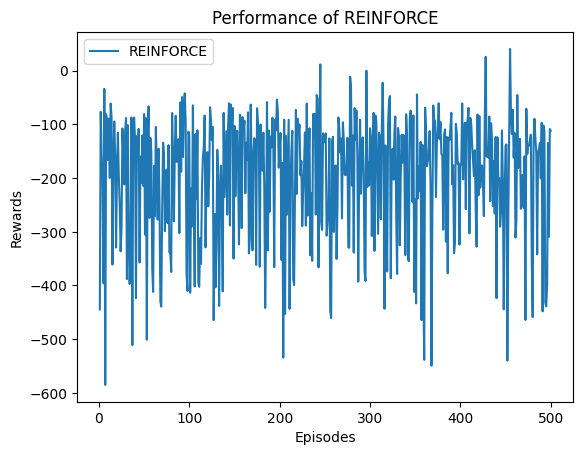

In [20]:
def main():
    env = gym.make("LunarLander-v2")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    policy_network = Policy_NN(state_size, action_size)

    n_episode = 500
    n_timesteps = 1000
    episode_array = [i for i in range(1,n_episode+1)]
    rewards_array = run(policy_network,env,n_episode)
    # discounted_rewards = []
    # R = 0
    # for reward in rewards:
    #     R = reward + policy_network.gamma * R
    #     discounted_rewards.insert(0,R)

    # # Compute policy loss
    # policy_loss = torch.stack(log_probs_array) * discounted_rewards
    # policy_loss = -policy_loss.sum()

    # # Update policy
    # optimizer.zero_grad()
    # policy_loss.backward()
    # optimizer.step()
    plt.title("Performance of REINFORCE")
    plt.plot(episode_array, rewards_array, label = "REINFORCE")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.legend()
    plt.show()

main()

Episode:0 | Reward: -264.5208536349353
Episode:1 | Reward: -286.6980426784191
Episode:2 | Reward: -406.05611233077803
Episode:3 | Reward: -119.28508148619957
Episode:4 | Reward: -380.1729737607536
Episode:5 | Reward: -287.622986608791
Episode:6 | Reward: -239.754774283036
Episode:7 | Reward: -258.76316204040023
Episode:8 | Reward: -55.068842619540185
Episode:9 | Reward: -273.7130916124892
Episode:10 | Reward: -335.40293927861757
Episode:11 | Reward: -270.43067910430904
Episode:12 | Reward: 17.420153492717375
Episode:13 | Reward: -147.85573363618244
Episode:14 | Reward: -362.28189360918816
Episode:15 | Reward: -334.4631502063911
Episode:16 | Reward: -62.12225785968976
Episode:17 | Reward: -176.8072593503716
Episode:18 | Reward: -274.8411058791912
Episode:19 | Reward: -151.8457349598921
Episode:20 | Reward: -131.68579399024492
Episode:21 | Reward: -354.1737952842291
Episode:22 | Reward: -400.53262156461807
Episode:23 | Reward: -100.76253872227072
Episode:24 | Reward: -104.29338338904779
